In [1]:
import math
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")
df.head()

,angle,center
0,0.000000,/home/lacho/sdcnd/Self-Driving-Car-Simulator/m...
1,0.000000,/home/lacho/sdcnd/Self-Driving-Car-Simulator/m...
2,0.000000,/home/lacho/sdcnd/Self-Driving-Car-Simulator/m...
3,-0.088554,/home/lacho/sdcnd/Self-Driving-Car-Simulator/m...
4,-0.382704,/home/lacho/sdcnd/Self-Driving-Car-Simulator/m...


In [3]:
# df['use'] = np.random.randint(0,11, size=df.shape[0]) > 7
# df = df[df.use | df.angle != 0]

0.794219611647
-1.0426954 1.1


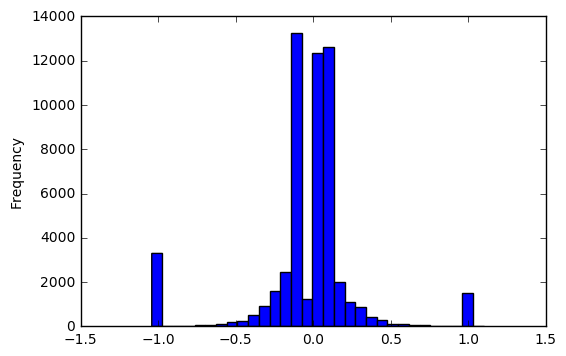

In [4]:
print(df.angle[df.angle != 0].count() / df.shape[0])
print(df.angle.min(), df.angle.max())
df.angle.plot(kind='hist', bins=31);

In [5]:
print('train samples:', df.shape[0])

train samples: 55671


In [6]:
def load_img(path, resize=True, crop_top=20, crop_bottom=-1):
    try:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if resize:
            img = cv2.resize(img,(160, 80), interpolation = cv2.INTER_CUBIC)
        if crop_top:
            img = img[crop_top:crop_bottom, :] 
    except:
        print(path)
        raise
    return img 

def ld_img(img):
#     return load_img(img, resize=True, crop_top=30, crop_bottom=-10)
#     return load_img(img, resize=False, crop_top=60, crop_bottom=-15)
    return load_img(img, resize=False, crop_top=60, crop_bottom=-1)

In [7]:
def data_generator(df, batch_size=64, iterations=1000000):
    for i in range(iterations):
        s = df.sample(batch_size)
        
        imgs = np.array([ld_img(im) for im in s.center.values])
        angles = s.angle.values
        imgs[:int(batch_size/2)] = [np.fliplr(im) for im in imgs[:int(batch_size/2)]]
        angles[:int(batch_size/2)] = -angles[:int(batch_size/2)]
        yield (imgs, angles)

def normalize(x):
    return x / 255.0 - 0.5

In [8]:
img = ld_img(df.center.iloc[0])
input_shape = img.shape
print(input_shape)

(99, 320, 3)


In [9]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [10]:


# 
# model.add(Activation('tanh'))
# model.add(Dropout(0.5))

model = Sequential()
model.add(Lambda(normalize, input_shape=input_shape))
model.add(Convolution2D(16, 5, 5, subsample=(2, 2), border_mode='valid', activation='elu'))
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='valid', activation='elu'))
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode='valid', activation='elu'))
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid', activation='elu'))
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='valid', activation='elu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

adam = Adam(lr=0.0001)
model.compile(loss='mse', optimizer=adam)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 99, 320, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 48, 158, 16)   1216        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 22, 77, 32)    12832       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 9, 37, 64)     51264       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [10]:
import json

def save_model(model, file_name='model'):
    model.save_weights('{}.h5'.format(file_name))
    with open('{}.json'.format(file_name), 'w') as file:
        json.dump(model.to_json(), file)
    print('model saved at', file_name)
    
    

In [11]:
from keras.models import model_from_json
with open('model.json', 'r') as jfile:
        model = model_from_json(json.load(jfile))

model.compile("adam", "mse")
model.load_weights('model.h5')


In [12]:
df_train, df_test = train_test_split(df, test_size=0.05, random_state=3)
df_train = df_train.copy()
print(df_train.shape, df_test.shape)

(52887, 2) (2784, 2)


In [13]:
df_train['random'] = np.random.randint(0,10, df_train.shape[0])
df_train = df_train[(df_train.angle != 0) | (df_train.random > 5)]
print(df_train.shape)

(46414, 3)


In [15]:

batch_size = 256
samples = batch_size * int(df_train.shape[0] / batch_size)
epochs = 5

history = model.fit_generator(data_generator(df_train, batch_size), 
                              validation_data=data_generator(df_test, batch_size), 
                              nb_val_samples=df_test.shape[0],
                              samples_per_epoch=samples, nb_epoch=epochs)
save_model(model)

Epoch 1/5
46336/46336 [==============================] - 72s - loss: 0.0209 - val_loss: 0.0146
Epoch 2/5
46336/46336 [==============================] - 70s - loss: 0.0202 - val_loss: 0.0178
Epoch 3/5
46336/46336 [==============================] - 72s - loss: 0.0200 - val_loss: 0.0179
Epoch 4/5
46336/46336 [==============================] - 73s - loss: 0.0195 - val_loss: 0.0158
Epoch 5/5
46336/46336 [==============================] - 72s - loss: 0.0197 - val_loss: 0.0140
model saved at model


In [16]:
save_model(model, 'model_20')

model saved at model_20


In [16]:
history.history

{'loss': [0.075493327362669838,
  0.046524371144672234,
  0.04412947881759869,
  0.041899705802400905,
  0.04025818801795443],
 'val_loss': [0.04109756276011467,
  0.035536228594454849,
  0.041046616028655662,
  0.03070858239450238,
  0.032529001208868896]}